# Clustering of Highest and Lowest Fitness Proteins

In this notebook we use a persistent homology informed DBSCAN to cluster the top `m` predicted protein sequences, and the bottom `m` protein sequences generated by ESM-2 for masked language modeling. In particular, we take a protein sequence, mask several positions in the protein sequence. Next, we compute a simple additive score of the fitness of a protein based on the sum of the log probabilities obtained from the logits for the masked sequence. Retrieving the top and bottom `m` predictions from the model, we then compute the persistent homology and persistence diagrams of each predicted sequence. Next, we compute the Wasserstein distances between each pair of persistence diagrams obtaining a distance matrix. We then compute persistent homology of this distance matrix, and use this to inform the parameter selection of a DBSCAN to obtain more nuanced clusters than those provided by $k$-Means of Agglomerative Clustering. Substituting HDBSCAN for DBSCAN allows us to form a hierarchical clustering that yields a tree of clusters which might be akin to a something like a phylogenetic tree. 


In [1]:
import ph_clustering_sequences as phcs
import predict_top_sequences as pts 

from transformers import AutoTokenizer, EsmModel, EsmForMaskedLM


In [2]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1. **Protein Sequences**: 

   The sequences represent the primary structure of proteins which is a linear chain of amino acids. Each sequence $S$ is represented as a string of characters, where each character represents a type of amino acid. We mask several positions, and then retrieve the top and bottom `m` predicted sequences given by ESM-2. 

In [3]:
# Test the function
sequence = "MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE"
mask_positions = [67, 82, 83]
m = 10
scores, bottom_full_sequences = pts.predict_bottom_full_sequences_nst(sequence, mask_positions, m)
scores, bottom_full_sequences

([-14.265785217285156,
  -14.301410675048828,
  -14.315254211425781,
  -14.321924209594727,
  -14.653836250305176,
  -14.412514686584473,
  -15.35557746887207,
  -14.949155807495117,
  -14.707834243774414,
  -15.060258865356445],
 ['MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNHCKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKWLPPPVRRIIGDLSNWCKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKMLPPPVRRIIGDLSNCCKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNCMKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNWWKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKWLPPPVRRIIGDLSNCWKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNC

In [4]:
# Get top `m` sequences
sequence = "MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE"
mask_positions = [67, 82, 83]
m = 10
scores, top_full_sequences = pts.predict_top_full_sequences(sequence, mask_positions, m)
scores, top_full_sequences

((-7.009411811828613,
  -6.982931137084961,
  -6.995639801025391,
  -6.860910415649414,
  -6.910654067993164,
  -6.841609954833984,
  -6.756624221801758,
  -6.730144500732422,
  -6.834429740905762,
  -6.815130233764648),
 ['MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKKLPPPVRRIIGDLSNKEKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKKLPPPVRRIIGDLSNLEKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKLLPPPVRRIIGDLSNPKKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKGLPPPVRRIIGDLSNKKKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKKLPPPVRRIIGDLSNPKKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKLLPPPVRRIIGDLSNKKKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKKLPPPVRRIIGDLSNKKKVLIGLDL

In [5]:
sequences = [top_full_sequences, bottom_full_sequences]
flattened_sequences = [seq for sublist in sequences for seq in sublist]
# flattened_sequences

2. **Persistence Diagrams**: 

   Topological Data Analysis (TDA) is a field that allows us to study the shape of our data. One of the tools in TDA is persistent homology, which is a method for identifying and quantifying features of a dataset such as loops, voids, and connected components. A persistence diagram is a multi-set of points in the plane that summarize the topological features of a dataset discovered during a filtration process. 

   Mathematically, a persistence diagram $D$ is a finite multiset of points $(b,d) \in \mathbb{R}^2$ where $b < d$. Each point $(b,d)$ represents a topological feature that appears at filtration value $b$ and disappears at $d$.

In [6]:
import torch

# Define layer to be used
num_layers = model.config.num_hidden_layers
layer = num_layers - 1  # Index of the last layer
sequences = flattened_sequences

# Initialize list to store persistent diagrams
persistent_diagrams = []

# Compute persistent homology for each sequence
for sequence in sequences:
    hidden_states_matrix = phcs.get_hidden_states(tokenizer, model, layer, sequence)
    distance_matrix = phcs.compute_euclidean_distance_matrix_scipy(hidden_states_matrix)
    _, persistence_diagram = phcs.compute_persistent_homology(distance_matrix)
    
    # Store the persistent diagram
    persistent_diagrams.append(persistence_diagram)

3. **Wasserstein Distances**:

   The Wasserstein distance, also known as the Earth Mover's distance, is a measure of the distance between two probability distributions. Given two persistence diagrams $D_1$ and $D_2$, the $p$-Wasserstein distance $W_p(D_1, D_2)$ between $D_1$ and $D_2$ is defined as:

   $$
   W_p(D_1, D_2) = \left(\inf_{\gamma \in \Gamma(D_1, D_2)} \sum_{(x,y) \in \gamma} \|x - y\|^p \right)^{1/p}
   $$

   where $\Gamma(D_1, D_2)$ denotes the set of all bijections $\gamma: D_1 \cup \Delta \to D_2 \cup \Delta$, and $\Delta$ is the diagonal in $\mathbb{R}^2$.

In [7]:
# Compute the Wasserstein distances between all pairs of persistence diagrams
wasserstein_distances = phcs.compute_wasserstein_distances(persistent_diagrams, 0)

4. Computing persistent homology once more, we get a persistence diagram for the collection of persistence diagrams we computed. This gives a summary of the differences in the protein sequences from a topological perspective. We can use it to inform our DBSCAN later on, but it is not needed for the $k$-Means, Agglomerative Clustering, or HDBSCAN. 

In [8]:
# Compute the persistent homology of the Wasserstein distance matrix
st_2, persistence_2 = phcs.compute_persistent_homology(wasserstein_distances)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

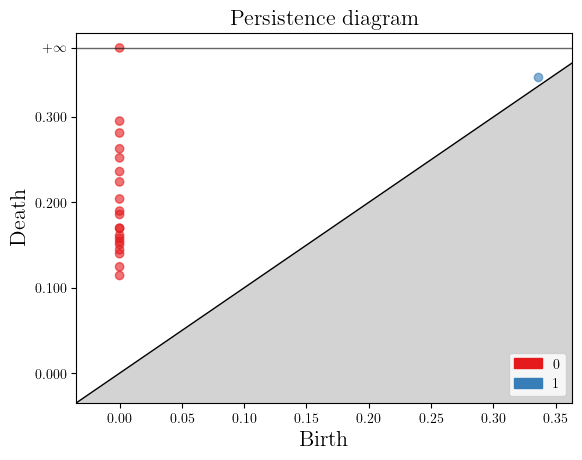

In [9]:
import gudhi as gd

# Plot the persistence diagram
gd.plot_persistence_diagram(persistence_2)

4. **Clustering**: 

   After computing the Wasserstein distances, we can use a clustering algorithm to group similar sequences together. Clustering algorithms like HDBSCAN, KMeans, Agglomerative Clustering, and DBSCAN work by grouping data points that are close to each other according to a given distance metric. 

   In this case, the distance metric is the Wasserstein distance. Thus, two sequences will be in the same cluster if their persistence diagrams (and hence their topological features) are close to each other in terms of the Wasserstein distance. 

5. **Minimum Spanning Tree and Cluster Hierarchy**: 

   For HDBSCAN, a minimum spanning tree of the distance weighted graph is built. The tree is then used to construct a cluster hierarchy of connected components. This hierarchy is then pruned based on the stability of clusters.

6. **Extracting Clusters**: 

   The final step is to extract the stable clusters from the cluster hierarchy to get a flat clustering. This is done by selecting clusters that have the greatest persistence, or in other words, that exist over a wide range of distance scales. This gives us a set of clusters that represent the main topological features of our data.


In [20]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(wasserstein_distances)
labels_kmeans = kmeans.labels_
print("Silhouette Coefficient for KMeans: %0.3f" % silhouette_score(wasserstein_distances, labels_kmeans))

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='average').fit(wasserstein_distances)
labels_agg = agg_clustering.labels_
print("Silhouette Coefficient for Agglomerative Clustering: %0.3f" % silhouette_score(wasserstein_distances, labels_agg))

# Perform DBSCAN clustering
dbscan = DBSCAN(metric="precomputed", eps=0.270, min_samples=2).fit(wasserstein_distances)
labels_dbscan = dbscan.labels_
if len(set(labels_dbscan)) > 1:  # More than 1 cluster
    print("Silhouette Coefficient for DBSCAN: %0.3f" % silhouette_score(wasserstein_distances, labels_dbscan))
else:
    print("Cannot compute Silhouette Coefficient for DBSCAN as there is only one cluster.")


Silhouette Coefficient for KMeans: 0.553
Silhouette Coefficient for Agglomerative Clustering: 0.553
Silhouette Coefficient for DBSCAN: 0.508


/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [21]:
# Print the clusters for KMeans
print("Clusters for KMeans:")
kmeans_clusters = {i: [] for i in set(labels_kmeans)}
for sequence, label in zip(sequences, labels_kmeans):
    kmeans_clusters[label].append(sequence)
for label, cluster in kmeans_clusters.items():
    print(f"Cluster {label}: {cluster}")

# Print the clusters for Agglomerative Clustering
print("\nClusters for Agglomerative Clustering:")
agg_clusters = {i: [] for i in set(labels_agg)}
for sequence, label in zip(sequences, labels_agg):
    agg_clusters[label].append(sequence)
for label, cluster in agg_clusters.items():
    print(f"Cluster {label}: {cluster}")

# Print the clusters for DBSCAN
print("\nClusters for DBSCAN:")
dbscan_clusters = {i: [] for i in set(labels_dbscan)}
for sequence, label in zip(sequences, labels_dbscan):
    dbscan_clusters[label].append(sequence)
for label, cluster in dbscan_clusters.items():
    print(f"Cluster {label}: {cluster}")


Clusters for KMeans:
Cluster 0: ['MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNHCKVLIGLDLLYEEIGDQAEDDLGLE', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKMLPPPVRRIIGDLSNCCKVLIGLDLLYEEIGDQAEDDLGLE', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNCMKVLIGLDLLYEEIGDQAEDDLGLE', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNWWKVLIGLDLLYEEIGDQAEDDLGLE', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKWLPPPVRRIIGDLSNCWKVLIGLDLLYEEIGDQAEDDLGLE', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNCCKVLIGLDLLYEEIGDQAEDDLGLE', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNWCKVLIGLDLLYEEIGDQAEDDLGLE', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKWLPPPVRRIIGDLSNCCKVLIGLDLLYEEIGDQAEDDLGLE', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLP

In [22]:
from sklearn.metrics import adjusted_rand_score

# Calculate ARIs
ari_kmeans_agg = adjusted_rand_score(labels_kmeans, labels_agg)
ari_kmeans_dbscan = adjusted_rand_score(labels_kmeans, labels_dbscan)
ari_agg_dbscan = adjusted_rand_score(labels_agg, labels_dbscan)

# Print ARIs
print(f"Adjusted Rand Index for KMeans and Agglomerative Clustering: {ari_kmeans_agg}")
print(f"Adjusted Rand Index for KMeans and DBSCAN: {ari_kmeans_dbscan}")
print(f"Adjusted Rand Index for Agglomerative Clustering and DBSCAN: {ari_agg_dbscan}")


Adjusted Rand Index for KMeans and Agglomerative Clustering: 1.0
Adjusted Rand Index for KMeans and DBSCAN: 0.5740387848895864
Adjusted Rand Index for Agglomerative Clustering and DBSCAN: 0.5740387848895864


In [23]:
import hdbscan

# Create an HDBSCAN instance with gen_min_span_tree set to True
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5, gen_min_span_tree=True)

# Fit the model with the data (distance matrix)
clusterer.fit(wasserstein_distances)

# Generate the minimum spanning tree
minimum_spanning_tree = clusterer.minimum_spanning_tree_

# If the minimum spanning tree was correctly generated, it should not be None
if minimum_spanning_tree is not None:
    minimum_spanning_tree.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=80, edge_linewidth=2)
else:
    print("The minimum spanning tree was not generated. Please check the parameters and the input data.")


The minimum spanning tree was not generated. Please check the parameters and the input data.


/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/hdbscan/hdbscan_.py:1429: UserWarning: No raw data is available; this may be due to using a precomputed metric matrix. No minimum spanning tree will be provided without raw data.
  warn(


<Axes: ylabel='distance'>

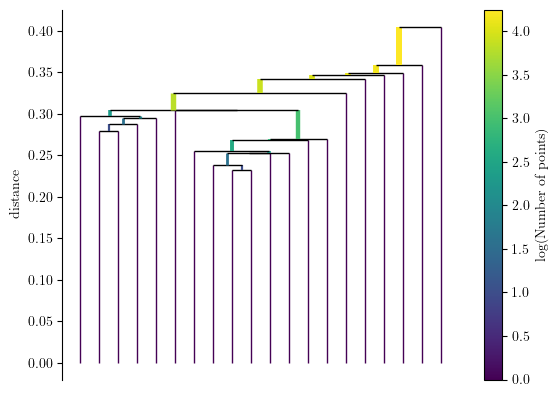

In [24]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)


In [25]:
import numpy as np
import hdbscan
from scipy.spatial.distance import squareform

# Create a condensed distance matrix
condensed_dist_matrix = squareform(wasserstein_distances)

# Use HDBSCAN on the distance matrix
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='precomputed', gen_min_span_tree=True)
clusterer.fit(wasserstein_distances)

# Obtain labels assigned by the HDBSCAN algorithm
labels_hdbscan = clusterer.labels_

# Group sequences by their cluster labels
clusters_hdbscan = {i: [] for i in set(labels_hdbscan)}
for i, label in enumerate(labels_hdbscan):
    clusters_hdbscan[label].append(sequences[i])

clusters_hdbscan


{0: ['MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKKLPPPVRRIIGDLSNKEKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKLLPPPVRRIIGDLSNPKKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKKLPPPVRRIIGDLSNPKKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKLLPPPVRRIIGDLSNKKKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKGLPPPVRRIIGDLSNLKKVLIGLDLLYEEIGDQAEDDLGLE'],
 1: ['MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIGDLSNHCKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKWLPPPVRRIIGDLSNWCKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKMLPPPVRRIIGDLSNCCKVLIGLDLLYEEIGDQAEDDLGLE',
  'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKCLPPPVRRIIG

<Axes: ylabel='$\\lambda$ value'>

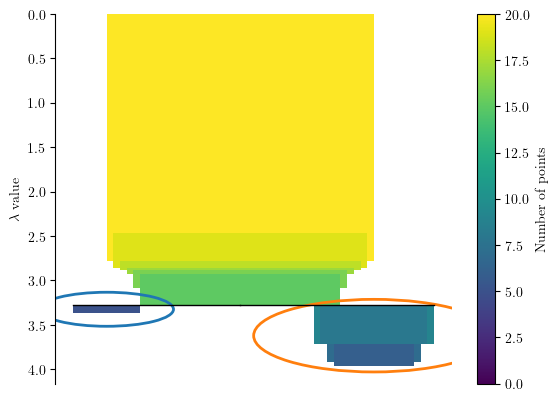

In [27]:
import seaborn as sns 

clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())